### Importing data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/sgmoid/

/content/gdrive/MyDrive/sgmoid


In [ ]:
!unzip train.zip
!mkdir train
!mv images masks train 

In [ ]:
!pip install torch-summary

### Importing libraries 

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
import numpy as np
import pandas as pd
import tqdm
import os
import time
import cv2
import glob
import random
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
from torchsummary import summary
from torchvision import transforms, models, utils
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.utils import shuffle

### Processing Data

In [ ]:
train_csv = pd.read_csv('train.csv')
train_csv['rle_mask'].fillna(-1, inplace = True)
train_csv['class'] = train_csv.apply(lambda x: x.rle_mask != -1, axis = 1)
train_labelled = train_csv.loc[train_csv['class'] == True].reset_index(drop=True)
train_unlabelled = train_csv.loc[train_csv['class'] == False]
depth_csv = pd.read_csv('depths.csv')
short_unlabelled = train_unlabelled.iloc[:781,:].reset_index(drop=True)
train_short_csv = pd.concat([train_labelled, short_unlabelled])
train_short_csv = shuffle(train_short_csv).reset_index(drop=True)

In [ ]:
def load_image(path, mask = False):
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, _ = img.shape

    # Padding in needed for UNet models because they need image size to be divisible by 32 
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)
    if mask:
        # Convert mask to 0 and 1 format
        img = img[:, :, 0:1] // 255
        return torch.from_numpy(np.transpose(img, (2, 0, 1)).astype('float32'))
        #return img.astype('float32')
    else:
        img = img / 255.0
        return torch.from_numpy(np.transpose(img, (2, 0, 1)).astype('float32'))
        #return img.astype('float32')

In [ ]:
train_transform = transforms.RandomApply([transforms.RandomRotation(degrees=10),
                                          transforms.RandomHorizontalFlip()], p=1.0)
                                          #transforms.ColorJitter(0.4,0.4,0.4)
                                          #transforms.ToTensor()

#train_transform = transforms.RandomApply([transforms.RandomRotation(degrees=10),
#                                          transforms.RandomHorizontalFlip()], p=1.0)
class salt(Dataset):
  def __init__(self, csv_file, train_dir, transform=None):
    self.train_dir = train_dir
    self.csv_file = csv_file
    self.transform = transform

    self.target_size = 128

  def __len__(self):
    return len(self.csv_file)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image_id = self.csv_file.loc[idx, 'id']
    image_folder = os.path.join(self.train_dir, "images")
    image_path = os.path.join(image_folder, image_id + ".png")
    image = load_image(image_path)
    mask_folder = os.path.join(self.train_dir, "masks")
    mask_path = os.path.join(mask_folder, image_id + ".png")
    mask = load_image(mask_path, mask = True)

    #sample = {'image':image, 'mask':mask}
    if self.transform:
        #sample = self.transform(sample)
        #image = transforms.ToPILImage()(np.uint8(image))
        #mask = transforms.ToPILImage()(np.uint8(mask))
        #plt.imshow(image)
        #(image, mask) = self.transform([image, mask])
        image = self.transform(image)
        mask = self.transform(mask)
    return image, mask

In [ ]:
train1 = salt(train_short_csv,'./train', transform=None)
train2 = salt(train_short_csv,'./train', transform=train_transform)
dataset = torch.utils.data.ConcatDataset([train1, train2])
#dataset = salt(train_csv,'./train', transform=None)

batch_size = 16
validation_split = .15
shuffle_dataset = True
random_seed= 42
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


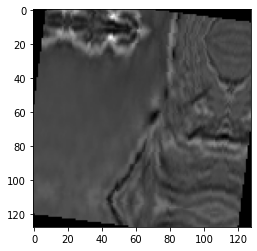

In [ ]:
plt.imshow(np.moveaxis(train2[15][0].cpu().numpy(),0,-1))

### VGG16 encoder

In [ ]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super(ConvRelu, self).__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x
class DecoderBlock(nn.Module):
  def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
    super(DecoderBlock, self).__init__()
    self.in_channels = in_channels

    if is_deconv:
      self.block = nn.Sequential(ConvRelu(in_channels, middle_channels),
                                 nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,padding=1),
                                 nn.ReLU(inplace=True))
    else:
      self.block = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                 ConvRelu(in_channels, middle_channels),
                                 ConvRelu(middle_channels, out_channels))

  def forward(self, x):
    return self.block(x)


class VGG16(nn.Module):
  def __init__(self, num_classes=1, num_filters=32, pretrained=True):
    """
    :param num_classes:
    :param num_filters:
    :param pretrained:
        False - no pre-trained network used
        True - encoder pre-trained with VGG11
    """
    super().__init__()
    self.num_classes = num_classes
    self.pool = nn.MaxPool2d(2, 2)
    self.encoder = torchvision.models.vgg16(pretrained=pretrained).features
    self.relu = nn.ReLU(inplace=True)
    self.conv1 = nn.Sequential(self.encoder[0],
                               self.relu,
                               self.encoder[2],
                               self.relu)
    self.conv2 = nn.Sequential(self.encoder[5],
                               self.relu,
                               self.encoder[7],
                               self.relu)
    self.conv3 = nn.Sequential(self.encoder[10],
                               self.relu,
                               self.encoder[12],
                               self.relu,
                               self.encoder[14],
                               self.relu)
    self.conv4 = nn.Sequential(self.encoder[17],
                               self.relu,
                               self.encoder[19],
                               self.relu,
                               self.encoder[21],
                               self.relu)
    self.conv5 = nn.Sequential(self.encoder[24],
                               self.relu,
                               self.encoder[26],
                               self.relu,
                               self.encoder[28],
                               self.relu)
    self.center = DecoderBlock(512, num_filters * 8 * 2, num_filters * 8)
    self.dec5 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8)
    self.dec4 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8)
    self.dec3 = DecoderBlock(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2)
    self.dec2 = DecoderBlock(128 + num_filters * 2, num_filters * 2 * 2, num_filters)
    self.dec1 = ConvRelu(64 + num_filters, num_filters)
    self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

  def forward(self, x):
    conv1 = self.conv1(x)
    conv2 = self.conv2(self.pool(conv1))
    conv3 = self.conv3(self.pool(conv2))
    conv4 = self.conv4(self.pool(conv3))
    conv5 = self.conv5(self.pool(conv4))

    center = self.center(self.pool(conv5))

    dec5 = self.dec5(torch.cat([center, conv5], 1))
    dec4 = self.dec4(torch.cat([dec5, conv4], 1))
    dec3 = self.dec3(torch.cat([dec4, conv3], 1))
    dec2 = self.dec2(torch.cat([dec3, conv2], 1))
    dec1 = self.dec1(torch.cat([dec2, conv1], 1))
    
    return torch.sigmoid(self.final(dec1))

### Resnet encoder

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, num_classes=1, num_channels=3, pretrained=True):
        super().__init__()
        assert num_channels == 3
        self.num_classes = num_classes
        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=pretrained)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder
        self.decoder4 = DecoderBlockLinkNet(filters[3], filters[2])
        self.decoder3 = DecoderBlockLinkNet(filters[2], filters[1])
        self.decoder2 = DecoderBlockLinkNet(filters[1], filters[0])
        self.decoder1 = DecoderBlockLinkNet(filters[0], filters[0])

        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3, stride=2)
        self.finalrelu1 = nn.ReLU(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nn.ReLU(inplace=True)
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    # noinspection PyCallingNonCallable
    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder with Skip Connections
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Final Classification
        f1 = self.finaldeconv1(d1)
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)

        if self.num_classes > 1:
            x_out = F.log_softmax(f5, dim=1)
        else:
            x_out = f5
        return torch.sigmoid(x_out)

class DecoderBlockLinkNet(nn.Module):
    def __init__(self, in_channels, n_filters):
        super().__init__()

        self.relu = nn.ReLU(inplace=True)

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)

        # B, C/4, H, W -> B, C/4, 2 * H, 2 * W
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        return x

In [ ]:
class LossBinary:
  """
  Loss defined as \alpha BCE - (1 - \alpha) SoftJaccard
  """

  def __init__(self, jaccard_weight=0):
    #self.nll_loss = nn.BCEWithLogitsLoss()
    self.nll_loss = nn.BCELoss()
    self.jaccard_weight = jaccard_weight

  def __call__(self, outputs, targets):
    loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

    if self.jaccard_weight:
      eps = 1e-15
      jaccard_target = (targets == 1).float()
      jaccard_output = torch.sigmoid(outputs)

      intersection = (jaccard_output * jaccard_target).sum()
      union = jaccard_output.sum() + jaccard_target.sum()

      loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
    return loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training 

In [ ]:
model = VGG16().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)
criterion = torch.nn.BCELoss()

In [ ]:
def train(model, criterion, train_loader, init_optimizer, epochs):
    model_name = 'VGG16_Binaryloss_adamw_wtransform'
    trial = '1'
    prev_epoch_save = ''
    optimizer = init_optimizer
    mean_loss_list = []
    for epoch in range(epochs):
        start = time.time()
        model.train()
        tq = tqdm.notebook.tqdm(total=(len(train_loader) * 16))
        tq.set_description('Epoch {}, lr {}'.format(epoch, 0.0001))
        losses = []
        mean_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            batch_size = inputs.size(0)
            loss.backward()
            optimizer.step()
            tq.update(batch_size)
            losses.append(loss.item())
            mean_loss = np.mean(losses)
            tq.set_postfix(loss='{:.5f}'.format(mean_loss))

        model.eval()
        with torch.no_grad():
            for i, (val_inputs, val_targets) in enumerate(validation_loader):
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_targets)
                #mean_val_loss = np.mean(val_loss.item())
                running_val_loss = val_loss.item() * val_inputs.shape[0]
                
        epoch_val_loss = running_val_loss / len(validation_loader)
        scheduler.step(epoch_val_loss)
        mean_loss_list.append(epoch_val_loss)
        tq.close()
        print(mean_loss_list)
        if mean_loss_list[-1] == min(mean_loss_list):
            print('yes')
            if prev_epoch_save:
                os.remove(prev_epoch_save)
            best_epoch_save = f"{model_name}_{trial}_epoch{epoch}.pth"
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict()},best_epoch_save)
            prev_epoch_save = best_epoch_save
    return 

In [ ]:
train(model, criterion, train_loader, optimizer, 30)

In [ ]:
torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer': optimizer.state_dict()},model_name)

### Testing and creating submission file

In [ ]:
!unzip test.zip

In [ ]:
test_images = glob.glob('images/*')
test_images.sort()
df_test = pd.DataFrame(test_images, columns = ['image_path'])

In [ ]:
class salt_test(Dataset):
  def __init__(self, test_data):
    self.test_data = test_data
    self.target_size = 128

  def __len__(self):
    return len(self.test_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image_path = test_images[idx]
    image = load_image(image_path)
    return image
test = salt_test(test_images)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1)

In [ ]:
test = salt_test(test_images)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [ ]:
checkpoint = torch.load('VGG16_Binaryloss_adamw_wtransform_1_epoch14.pth')
model = VGG16().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
pred = []
model.eval()
with torch.no_grad():
    for i in range(len(df_test)):
        img = load_image(df_test.loc[i,'image_path'])
        img = torch.from_numpy(np.expand_dims(img, axis=0).astype('float32'))
        img = img.to(device)
        outputs = model(img)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.moveaxis(outputs, 0, -1)
        pred.append(outputs)
        if i%100 ==0:
            print(f"done {i}")
        

In [ ]:
predictions = np.array(pred)

In [ ]:
height, width = 101, 101

if height % 32 == 0:
    y_min_pad = 0
    y_max_pad = 0
else:
    y_pad = 32 - height % 32
    y_min_pad = int(y_pad / 2)
    y_max_pad = y_pad - y_min_pad

if width % 32 == 0:
    x_min_pad = 0
    x_max_pad = 0
else:
    x_pad = 32 - width % 32
    x_min_pad = int(x_pad / 2)
    x_max_pad = x_pad - x_min_pad

In [ ]:
pp = predictions.squeeze()
pp = pp[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]

In [ ]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
test_idx = [df_test.loc[idx,'image_path'][7:-4] for idx in range(len(df_test))]
pred_dict={}
for i, idx in enumerate(test_idx):
    pred_dict[idx] = rle_encode(np.round(pp[i]))

In [ ]:
submission = pd.DataFrame.from_dict(pred_dict, orient='index')
submission.index.names = ['id']
submission.columns = ['rle_mask']
submission.to_csv('submission.csv')